In [1]:
import pandas as pd
import geopandas as gpd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
#pip install geopandas
#pip install spacy
#python -m spacy download en_core_web_sm

In [2]:
# read in the dataset 
df = pd.read_json('animal_news_database.json', lines = True)
# Read in the datasets defining our subset data

#undoc = pd.read_csv("undoc_species.csv", sep = ";")
charismatic = pd.read_csv("charismatic_16.csv", sep = ";")
#edge = pd.read_csv("non_charismatic_20.csv", sep = ";")

In [3]:
charismatic = charismatic.rename(columns = {'Scientifc Name' : 'scientific_name'})
#charismatic = charismatic[['scientific_name', 'Ecosystem', 'Class']]
#edge = edge.rename(columns = {'Scientifc Name' : 'scientific_name'})
#edge = edge[['scientific_name', 'Ecosystem', 'Class', 'Conservation Attention']]

In [4]:
# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)
# How many species listed total in this dataset
#df['scientific_name'].nunique()

# Add new column for storing the values article amount found under each species type 
df['article_amt'] = df['articles'].str.len()
    
## Good syntax to remember to find specific instances of a value in a specific column
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

In [5]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')


#df.head()

In [6]:
df = df.drop(['_id'], axis=1)

In [7]:
# Do the same for the entire dataframe
rizz = df.merge(charismatic, on = 'scientific_name', how = 'inner')
#dg = df.merge(edge, on = 'scientific_name', how = 'inner')

In [8]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('General ID name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

# Filter out species with less than 10 articles, not enough data 
#article_totals = article_totals[article_totals > 5]
article_totals_rz.nlargest(20)

General ID name
Whale         542
Bear          531
Crocodile     463
Rhinoceros    353
Dolphin       206
Gorilla       173
Elephant      151
Lion          138
Wolf          127
Tiger         102
Panther        95
Shark          53
Cheetah        52
Zebra          45
Chimpanzee     44
Panda          33
Name: article_amt, dtype: int64

In [9]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('scientific_name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

# Filter out species with less than 10 articles, not enough data 
#article_totals = article_totals[article_totals > 5]
article_totals_rz.nlargest(20)

scientific_name
Panthera leo                138
Ursus arctos                132
Canis lupus                 127
Ursus arctos isabellinus    123
Rhinoceros unicornis        118
Gorilla beringei            104
Panthera tigris             102
Ursus thibetanus            101
Gavialis gangeticus          89
Eschrichtius robustus        81
Panthera pardus              81
Crocodylus porosus           78
Loxodonta africana           77
Ceratotherium simum          75
Crocodylus palustris         74
Elephas maximus              74
Tremarctos ornatus           71
Gorilla gorilla              69
Helarctos malayanus          69
Orcaella brevirostris        57
Name: article_amt, dtype: int64

In [10]:
# Explode the articles column
s = rizz['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
rizz_articles = rizz.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))

In [11]:
# Processing for articles       
# keep only unique article instances
rizz_media = rizz_articles.drop_duplicates(subset=['text'])

# Transform date column into DateTime
rizz_media["date"] = pd.to_datetime(rizz_media["date"])
# Sort by oldest to newest
rizz_media = rizz_media.sort_values(by="date")

/tmp/ipykernel_116/1326665575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rizz_media["date"] = pd.to_datetime(rizz_media["date"])


In [12]:
rizz_media = rizz_media.drop(columns=['Unnamed: 8', 'article_amt'])
rizz_media.reset_index(drop = True, inplace = True)
rizz_media = rizz_media[rizz_media['text'].notna()]
rizz_media

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class_x,Order,Family,Genus,...,Class_y,Ecosystem,Appendix,"Appendix exceptions, if any",text,title,link,image,date,ner
0,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,Mammal,Terrestrial,1,NaN,"TEMPO.CO, Jakarta - Indonesia is home to two o...",Sumatran Rhino Population Critical,https://news.google.com/articles/CBMiQmh0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Indonesia is ho..."
1,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,Mammal,Terrestrial,1,NaN,"TEMPO.CO, Jakarta - Director of the Biodiversi...",Javan Rhinos to be Transferred to Cikepuh Wild...,https://news.google.com/articles/CBMiWmh0dHBzO...,https://statik.tempo.co/data/2011/12/29/id_100...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Director of the..."
2,Grevy's Zebra,Equus grevyi,"Djibouti, Ethiopia, Kenya, Somalia, South Sudan",EN,2020-06-18,Animalia,Mammalia,Perissodactyla,Equidae,Equus,...,Mammal,Terrestrial,1,NaN,Share\n\n\n\n\n\n\n\n\n\n\n\nA Grevy’s Zebra f...,California zoo welcomes Grevy’s zebra colt foal,https://news.google.com/articles/CBMiSGh0dHBzO...,https://i1.wp.com/www.horsetalk.co.nz/wp-conte...,2001-11-30,"[{'sent': 'A Grevy’s', 'ents': {'ORG': ['Grevy..."
3,Tucuxi,Sotalia fluviatilis,"Brazil, Colombia, Costa Rica, Ecuador, Nicarag...",Data Deficient,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Sotalia,...,Mammal,Aquatic,1,NaN,At the Institute for Marine Mammal Studies in ...,Why dolphins are deep thinkers,https://news.google.com/articles/CBMiQGh0dHBzO...,https://i.guim.co.uk/img/static/sys-images/Env...,2003-07-03,[{'sent': 'At the Institute for Marine Mammal ...
4,Western Gorilla,Gorilla gorilla,"Angola, Cameroon, Central African Republic, Co...",CR,2020-06-18,Animalia,Mammalia,Primates,Hominidae,Gorilla,...,Mammal,Terrestrial,1,NaN,By Helen Briggs\n\nBBC News Online science rep...,Gorilla study gives social clues,https://news.google.com/articles/CBMiNWh0dHA6L...,http://newsimg.bbc.co.uk/media/images/39953000...,2004-03-23,"[{'sent': 'By Helen Briggs ', 'ents': {'PERSO..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Orcaella,...,Mammal,Aquatic,1,NaN,The Campaign to Ban Trophy Hunting’s (CBTH) fo...,A new book could be the final nail in the coff...,https://news.google.com/articles/CAIiEGKvqlzhh...,https://www.thecanary.co/wp-content/uploads/20...,2020-05-30,[{'sent': '(CBTH) founder Eduardo Gonçalves ha...
2845,Fin Whale,Balaenoptera physalus,"Algeria, Angola, Antarctica, Argentina, Austra...",VU,2020-06-18,Animalia,Mammalia,Cetacea,Balaenopteridae,Balaenoptera,...,Mammal,Aquatic,1,NaN,A 12-metre-long fin whale which washed up at H...,Fin whale washed up on Essex beach has been re...,https://news.google.com/articles/CBMiUmh0dHBzO...,https://www.scubadivermag.com/wp-content/uploa...,2020-05-30,[{'sent': 'A 12-metre-long fin whale which was...
2846,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Orcaella,...,Mammal,Aquatic,1,NaN,"In a unique initiative, researchers from the I...",IIT researchers help Chilika Lake in Odisha to...,https://news.google.com/articles/CBMiiwFodHRwc...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,"[{'sent': 'In a unique initiative, researchers..."
2847,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,Mammal,Terrestrial,1,NaN,Lonzo

In [13]:
# A new analysis of article amounts per species after text duplicates have been removed
rz_group = rizz_media.groupby('scientific_name')
totalz = rz_group.sum().round()
speciestop = totalz['Count'].nlargest(20)

rz_group = rizz_media.groupby('General ID name')
totalz = rz_group.sum().round()
general_IDtop = totalz['Count'].nlargest(20)

/tmp/ipykernel_116/1718699019.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()
/tmp/ipykernel_116/1718699019.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()


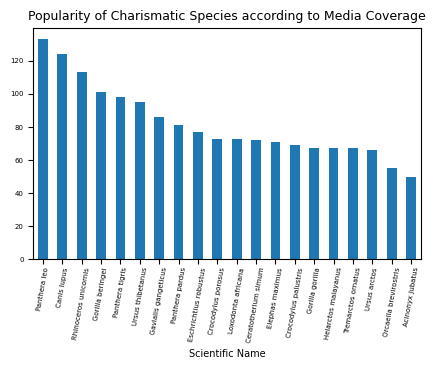

In [29]:
# What Charismatic species are given the most coverage?
# Create a simple bar graph displaying the amt of articles per species 
        
ax = speciestop.plot.bar(figsize = (5,3), fontsize = 5)
ax.set_xlabel('Scientific Name', fontsize=7)
ax.set_title('Popularity of Charismatic Species according to Media Coverage', fontsize = 9)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
#plt.savefig('top_20_species.png', bbox_inches = 'tight')

In [16]:
TF_CPP_MIN_LOG_LEVEL="2"

In [28]:
import spacy 
nlp = spacy.load('en_core_web_lg')

# Create a new column named 'processed_txt'
rizz_media['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
rizz_media['processed_txt'] = rizz_media['text'].apply(nlp)

rizz_media.reset_index(drop=True, inplace=True)   

In [19]:
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')
#Function retrieved from https://www.dataknowsall.com/textcleaning.html

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


In [21]:
#rizz_media['text_clean'] = rizz_media['text'].apply(lambda x: clean_string(x, stem='Stem'))
#rizz_media['text_clean_lem'] = rizz_media['text'].apply(lambda x: clean_string(x, stem='Lem'))
rizz_media['text_clean_spcy'] = rizz_media['text'].apply(lambda x: clean_string(x, stem='Spacy'))

In [ ]:
# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
rizz_media['spacy'] = rizz_media['text_clean_spcy'].apply(nlp)

In [22]:
# Define a function named 'get_ents' that takes a single object as input.
# We refer to this input using the variable name 'nlp_text'.
def get_ents(nlp_text, label):
    
    # First we make sure that the input is of correct type
    # by using the assert command to check the input type
    assert type(nlp_text) == spacy.tokens.doc.Doc
    
    # Let's set up a placeholder list for our ne's
    ents = []
    
    # We begin then begin looping over the Doc object
    for ent in nlp_text.ents:
        if (ent.label_ == label):
    
            # Append the ent text and label to the list of ents as a tuple
            ents.append(ent.text)
            
    # When the loop is complete, return the list of ents
    return ents

In [29]:
# Apply the 'get_ents' function to the column 'processed_txt'
#Create individual lists in order to store the values of different ents labels separately 
gpe_list = []
org_list = []
loc_list = []
event_list = []
norp_list = []

for i in rizz_media['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list.append(x)
    
    y = get_ents(i, "ORG")
    org_list.append(y)
    z = get_ents(i, "LOC")
    loc_list.append(z)
    v = get_ents(i, "EVENT")
    event_list.append(v)
    w = get_ents(i, "NORP")
    norp_list.append(w)
   

In [67]:
gpe_df = pd.DataFrame({"GPE":gpe_list})
loc_df = pd.DataFrame({"LOC":loc_list})
org_df = pd.DataFrame({"ORG":org_list})
rz = pd.concat([rizz_media, gpe_df, loc_df, org_df], axis = 1)

In [34]:
rz['url'] = None
test = []

for link in rz['link']:
    coded = link.strip("https://news.google.com/articles/")
    
    url = base64.b64decode(coded + '==')[4:].decode('utf-8', "backslashreplace").split('\\')[0]
    #dic = {'url': [url]}
    #rizz_media.append(pd.DataFrame(dic))
    test.append(url)


['https://en.tempo.co/read/806444/sumatran-rhino-population-critical',
 'https://en.tempo.co/read/878302/javan-rhinos-to-be-transferred-to-cikepuh-wildlife-reserve',
 'https://www.horsetalk.co.nz/2014/06/05/california-zoo-grevys-zebra-foal/',
 'https://www.theguardian.com/science/2003/jul/03/research.science',
 'http://news.bbc.co.uk/2/hi/science/nature/3557957.stm',
 'https://news.mongabay.com/2005/09/poverty-decimates-great-apes/',
 'http://news.bbc.co.uk/2/hi/science/nature/4700418.stm',
 'http://news.bbc.co.uk/2/hi/science/nature/5122074.stm',
 'https://ecofriend.org/endangered-north-pacific-right-whale-may-get-separate-listing/',
 '\x01https://www.independent.co.uk/environment/nature/navy-sonar-blamed-for-death-of-beaked-whales-found-washed-up-in-the-hebrides-805399.html',
 'https://www.floridamuseum.ufl.edu/science/fossils-from-bahamian-blue-hole-may-give-clues-to-early-life$',
 'https://www.reuters.com/article/us-whales/retreating-antarctic-sea-ice-threatens-southern-whales-idUS

In [38]:
"""Decode encoded Google News entry URLs."""
import base64
import functools
import re

# Ref: https://stackoverflow.com/a/59023463/

_ENCODED_URL_PREFIX = "https://news.google.com/articles/"
_ENCODED_URL_RE = re.compile(fr"^{re.escape(_ENCODED_URL_PREFIX)}(?P<encoded_url>[^?]+)")
_DECODED_URL_RE = re.compile(rb'^\x08\x13".+?(?P<primary_url>http[^\xd2]+)\xd2\x01')


@functools.lru_cache(2048)
def _decode_google_news_url(url: str) -> str:
    match = _ENCODED_URL_RE.match(url)
    encoded_text = match.groupdict()["encoded_url"]  # type: ignore
    encoded_text += "==="  # Fix incorrect padding. Ref: https://stackoverflow.com/a/49459036/
    decoded_text = base64.urlsafe_b64decode(encoded_text)

    match = _DECODED_URL_RE.match(decoded_text)
    primary_url = match.groupdict()["primary_url"]  # type: ignore
    primary_url = primary_url.decode()
    return primary_url


def decode_google_news_url(url: str) -> str:  # Not cached because not all Google News URLs are encoded.
    """Return Google News entry URLs after decoding their encoding as applicable."""
    return _decode_google_news_url(url) if url.startswith(_ENCODED_URL_PREFIX) else url

In [71]:
for url in rz['link']:
    try:
        new = decode_google_news_url(url)
        
    except AttributeError:
        rz.drop(rz.loc[rz.link == url].index, inplace = True)
        
    finally:
        ## HOW do I update the link to the new decoded one?? Or how do I append to dataframe in new column? 
        # Shouldn't this be simpler D:
        rz.at[url.index, 'link'] = new

TypeError: must be str, not DataFrame

In [32]:
s = rz.explode('GPE').groupby('scientific_name')['GPE'].value_counts()
s.to_csv("GPE_species_count.csv", sep = ';')

In [33]:
GPE_count = pd.read_csv("GPE_species_count.csv", sep = ';')
GPE_count

,scientific_name,GPE,GPE.1
0,Acinonyx jubatus,India,43
1,Acinonyx jubatus,Iran,35
2,Acinonyx jubatus,cubs,10
3,Acinonyx jubatus,Savannah,8
4,Acinonyx jubatus,Madhya Pradesh,6
...,...,...,...
8773,Ursus thibetanus,the Mysore Zoo,1
8774,Ursus thibetanus,the Republic of Korea,1
8775,Ursus thibetanus,the United Kingdom,1
8776,Ursus thibetanus,warthogs,1


In [26]:
x = speciestop.to_frame()

In [28]:
x

,Count
scientific_name,
Panthera leo,133
Canis lupus,124
Rhinoceros unicornis,113
Gorilla beringei,101
Panthera tigris,98
Ursus thibetanus,95
Gavialis gangeticus,86
Panthera pardus,81
Eschrichtius robustus,77


In [31]:
top20_GPE = GPE_count.merge(x, on = 'scientific_name', how = 'inner')
top20_GPE = top20_GPE.rename(columns = {'GPE.1' : 'GPE_count', 'Count' : 'article_count'})

In [33]:
top20_GPE.to_csv("20species_GPEtags.csv", sep = ';')

In [50]:
grouped = top20_GPE.groupby('scientific_name')

for x, y in grouped:
    print(y.loc[y['GPE_count'] > 6])

    scientific_name       GPE  GPE_count  article_count
0  Acinonyx jubatus     India         43             50
1  Acinonyx jubatus      Iran         35             50
2  Acinonyx jubatus    Russia          8             50
3  Acinonyx jubatus  Savannah          8             50
4  Acinonyx jubatus  Virginia          8             50
    scientific_name                GPE  GPE_count  article_count
159     Canis lupus         California         80            124
160     Canis lupus           Colorado         69            124
161     Canis lupus         Washington         57            124
162     Canis lupus          Minnesota         50            124
163     Canis lupus             Oregon         47            124
164     Canis lupus              Getty         38            124
165     Canis lupus               U.S.         32            124
166     Canis lupus         New Mexico         29            124
167     Canis lupus            Montana         28            124
168     Canis 

In [51]:
## SAVE DATAFRAME TO MAKE WORKING EASIER
rz.to_csv("rizz_media.csv", sep = ';')

In [23]:
def list_to_graph(name):

    # Set up the placeholder list
    final_list = []

    # Loop over each list in the list of lists
    for nlist in name:
    
        # Extend the final list with the current list
        final_list.extend(nlist)
    
    # Convert the list into a pandas Series, count unique nouns
    # using the value_counts() method, get the 10 most frequent
    # items [:10] and plot the result into a bar chart using the
    # plot() method and its attribute 'kind'.
    return pd.Series(final_list).value_counts()[:15].plot(kind='bar')

<AxesSubplot: >

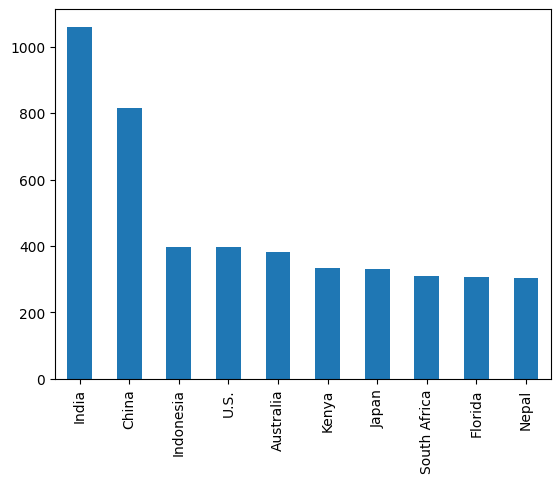

In [24]:
list_to_graph(gpe_list)

<AxesSubplot: >

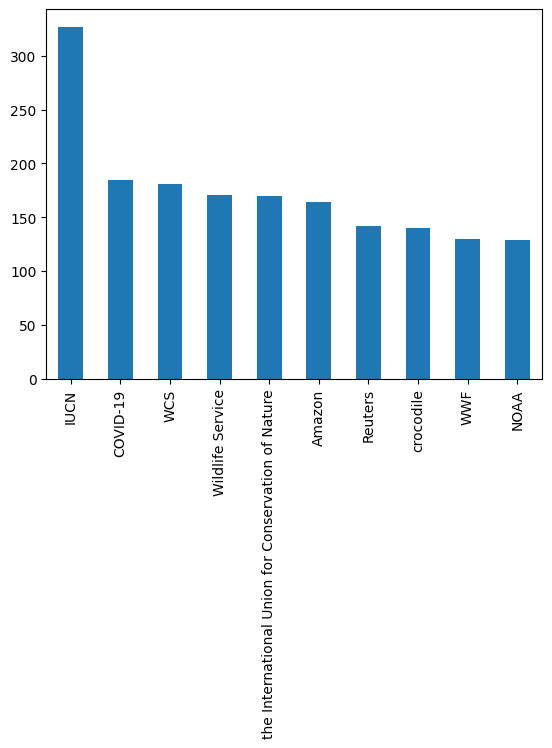

In [25]:
list_to_graph(org_list)

<AxesSubplot: >

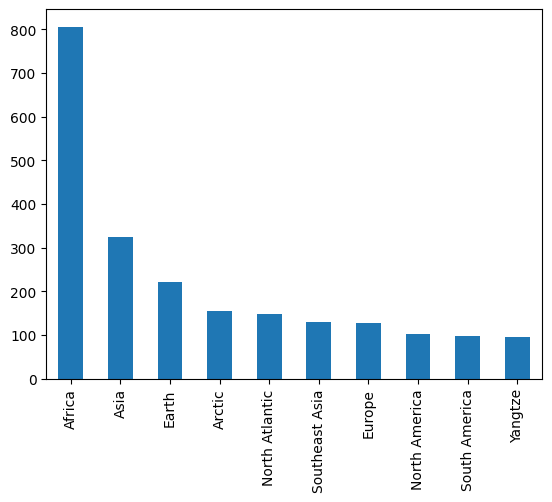

In [26]:
list_to_graph(loc_list)

<AxesSubplot: >

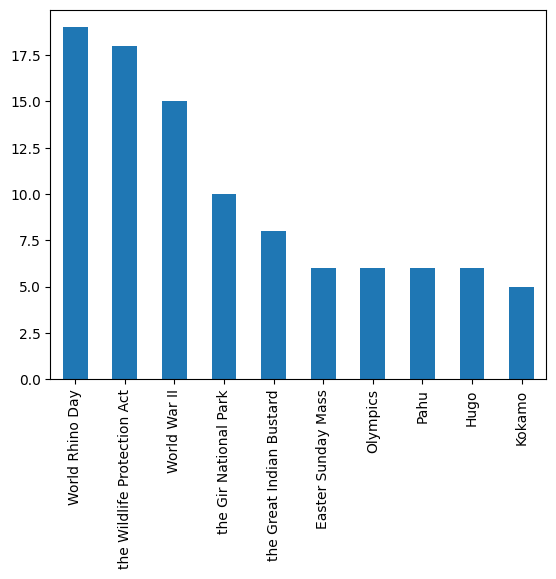

In [27]:
list_to_graph(event_list)

<AxesSubplot: >

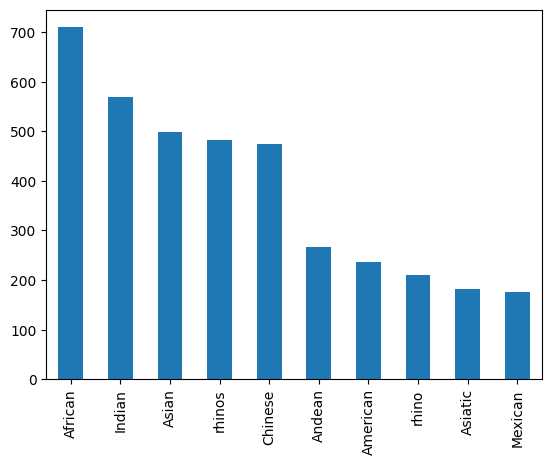

In [28]:
list_to_graph(norp_list)

In [65]:
# create a dataframe of the articles found under each species instance 
# How to bring over the species names that have been "identified" for each article? **

top_media = pd.DataFrame()

for i in top_twen.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        top_media = pd.concat([top_media, nd])
        
        
# keep only unique article instances
top_media = top_media.drop_duplicates(subset=['text'])

# Transform date column into DateTime
top_media["date"] = pd.to_datetime(top_media["date"])
# Sort by oldest to newest
top_media = top_media.sort_values(by="date")
## lets run a quick keyword search
# 71 articles identified out of 1887. That is 3% of the dataset for Top 20 species
# Manual classification to asses what species are mentioned, geographic locations, reporting agency, information provided, accuracy and relevancy of information in conservation research of the species 
#illegaltrade_top20_articles = top20[top20['text'].str.contains('seiz|confiscat')]
#top_media[top_media['text'].str.contains('seiz|confiscat|trade|poach')]
# Save articles dataframe
#illegaltrade_top20_articles.to_csv("illegaltrade_top20_articles.csv")
top_media

,text,title,link,image,date,ner
0,The Cruel Wildlife Market\n\nHundreds of cages...,Indonesia Field Report IV: The Last Twitch? Wi...,https://news.google.com/articles/CBMilwFodHRwc...,https://www.brookings.edu/wp-content/uploads/2...,2001-11-30,"{'sent': 'Hundreds of cages with birds, lizard..."
0,Naismith went to the toilet after her plane ha...,Collectors feed bizarre smuggling escapades,https://news.google.com/articles/CBMiY2h0dHBzO...,https://www.theage.com.au/theage.png,2007-03-11,{'sent': 'She said she went to Singapore for a...
0,The long-nosed bandicoot has made a return to ...,Long-nosed bandicoot returns to inner Sydney,https://news.google.com/articles/CBMiWmh0dHBzO...,https://www.abc.net.au/cm/rimage/651260-16x9-l...,2007-08-26,{'sent': 'The long-nosed bandicoot has made a ...
0,A TRAWDEN man couldn’t believe his eyes when h...,'Albino' bird lands in Trawden,https://news.google.com/articles/CBMiUmh0dHBzO...,https://www.lancashiretelegraph.co.uk/resource...,2008-07-06,"{'sent': 'Stunned Alan Southworth, 74, of Boul..."
0,"In 2007, an inspired group of sea turtle resea...",The Great Turtle Race begins again!,https://news.google.com/articles/CBMiR2h0dHBzO...,https://deepseanews.com/wp-content/uploads/200...,2009-04-16,"{'sent': 'In 2007, an inspired group of sea tu..."
...,...,...,...,...,...,...
0,"Creatures in forests, oceans, zoos, and even i...",21 mind-boggling world records held by animals,https://news.google.com/articles/CAIiEByfE3XWr...,https://i.insider.com/5ea6f630d553f8036c5b76b2...,2020-05-30,{'sent': 'The longest crocodile in captivity m...
0,Sign up to FREE email alerts from Nottinghamsh...,Grave of Notts man 'mauled' by tiger in 1915 u...,https://news.google.com/articles/CBMiU2h0dHBzO...,https://i2-prod.nottinghampost.com/incoming/ar...,2020-05-30,{'sent': 'Sign up to FREE email alerts from No...
0,India batsman K.L. Rahul has applauded the unw...,KL Rahul hails relentless efforts of frontline...,https://news.google.com/articles/CAIiECaj5dLA_...,https://www.thestatesman.com/wp-content/upload...,2020-05-30,{'sent': 'India batsman K.L. Rahul has applaud...
0,Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,{'sent': 'Lonzo Ball is never one to shy away ...


In [66]:
# Create a new column named 'processed_txt'
top_media['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
top_media['processed_txt'] = top_media['text'].apply(nlp)

# Apply the 'get_ents' function to the column 'processed_txt'
#Create individual lists in order to store the values of different ents labels separately 
gpe_list1 = []
org_list1 = []
loc_list1 = []
event_list1 = []
norp_list1 = []

for i in top_media['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list1.append(x)
    
    y = get_ents(i, "ORG")
    org_list1.append(y)
    z = get_ents(i, "LOC")
    loc_list1.append(z)
    v = get_ents(i, "EVENT")
    event_list1.append(v)
    w = get_ents(i, "NORP")
    norp_list1.append(w)

<AxesSubplot: >

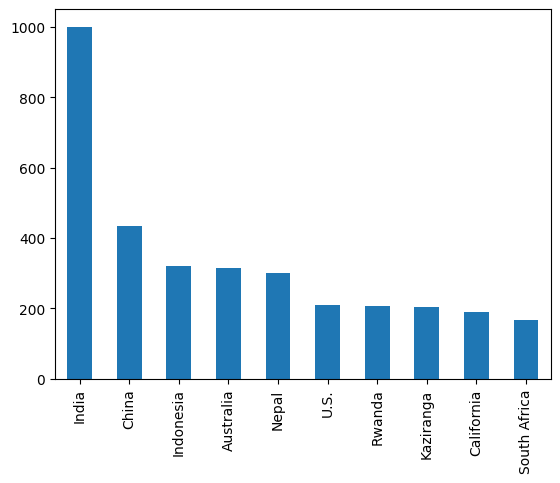

In [67]:
list_to_graph(gpe_list1)

<AxesSubplot: >

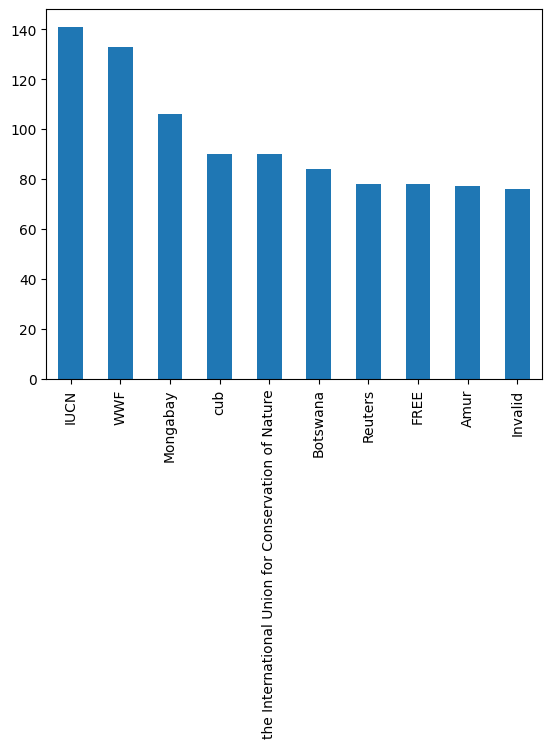

In [68]:
list_to_graph(org_list1)

<AxesSubplot: >

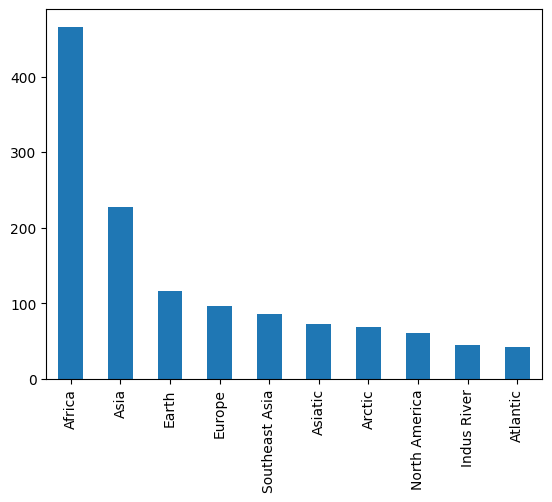

In [69]:
list_to_graph(loc_list1)

<AxesSubplot: >

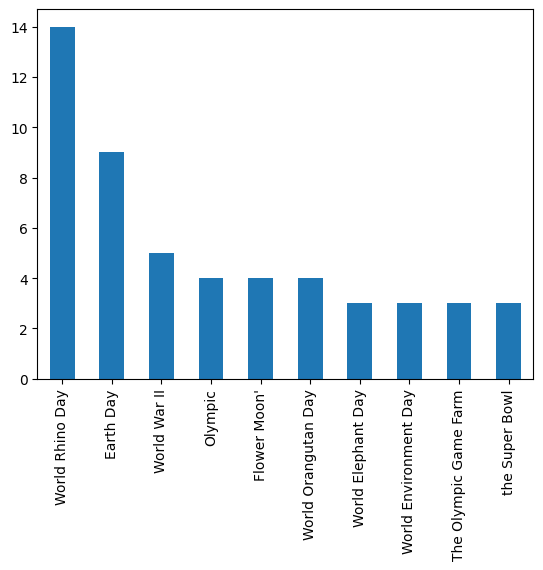

In [70]:
list_to_graph(event_list1)

<AxesSubplot: >

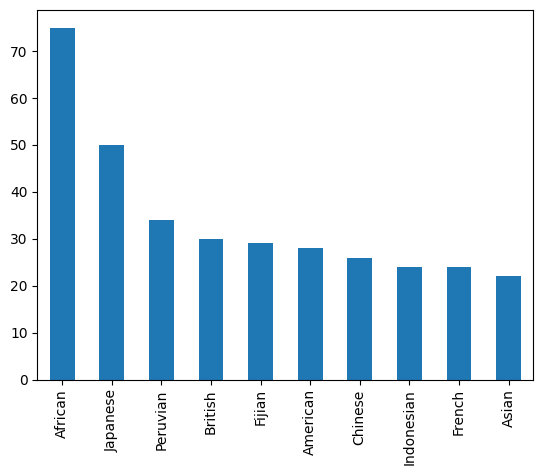

In [71]:
list_to_graph(norp_list)

# BACK to WHOLE DATASET SAMPLE

In [10]:
# Whole dataset articles
read = pd.DataFrame()

for i in df.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        read = pd.concat([read, nd])

# keep only unique article instances
read = read.drop_duplicates(subset=['text'])

# Transform date column into DateTime
read["date"] = pd.to_datetime(read["date"])
# Sort by oldest to newest
read = read.sort_values(by="date")

read.head()

KeyboardInterrupt: 

<AxesSubplot:xlabel='date'>

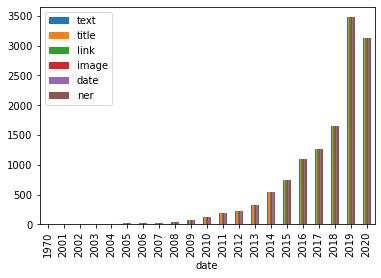

In [20]:
# Create a quick visualization of the date distribution 
read.groupby(read["date"].dt.year).count().plot(kind="bar")

In [15]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

#cites1 = cites1.rename(columns = {'FullName' : 'scientific_name'})

cites1

,Kingdom,Class,Order,Family,Genus,Species,Scientific Name,Listing,NativeDistributionFullNames,Extinct_Distribution
0,Animalia,Mammalia,Artiodactyla,Antilocapridae,Antilocapra,americana,Antilocapra americana,I,"Canada,Mexico,United States of America",NaN
1,Animalia,Mammalia,Artiodactyla,Bovidae,Addax,nasomaculatus,Addax nasomaculatus,I,"Chad,Mali,Mauritania,Niger,Sudan","Algeria,Egypt,Libya,Morocco,Tunisia,Western Sa..."
2,Animalia,Mammalia,Artiodactyla,Bovidae,Bos,gaurus,Bos gaurus,I,"Bangladesh,Bhutan,Cambodia,China,India,Lao Peo...",Sri Lanka
3,Animalia,Mammalia,Artiodactyla,Bovidae,Bos,mutus,Bos mutus,I,"China,India,Nepal","Kazakhstan,Mongolia,Russian Federation"
4,Animalia,Mammalia,Artiodactyla,Bovidae,Bos,sauveli,Bos sauveli,I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1132,Plantae,NaN,Cycadales,Zamiaceae,Encephalartos,villosus,Encephalartos villosus,I,"Eswatini,Mozambique,South Africa",NaN
1133,Plantae,NaN,Cycadales,Zamiaceae,Encephalartos,whitelockii,Encephalartos whitelockii,I,Uganda,NaN
1134,Plantae,NaN,Cycadales,Zamiaceae,Encephalartos,woodii,Encephalartos woodii,I,NaN,South Africa
1135,Plantae,NaN,Cycadales,Zamiaceae,Microcycas,calocoma,Microcycas calocoma,I,Cuba,NaN


In [17]:
# Simplify the IUCN categories

df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC", 
                                "Vulnerable" : "VU", "Near Threatened" : "NT", "Critically Endangered" : "CR",
                          "Extinct in the Wild" : "EW", "Endangered" : "EN", "Data Deficient" : "DD", 
                          "Extinct" : "EX"}, inplace=True)

df['iucn_status'].unique()

## DROP NA
df_mod = df[ (df['iucn_status'] != 'NA') & (df['iucn_status'] != ' Brede & Rödel')]
df_mod
#df.drop(df.loc[df['iucn_status'].isin(['NA'])])
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

/tmp/ipykernel_93/1468945897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC",


array(['CR', 'LC', 'NT', 'NA', 'EW', 'VU', 'EN', 'DD', 'EX',
       'Lower Risk/conservation dependent', ' Brede & Rödel'],
      dtype=object)

In [19]:
# Assigning each category a more relevant color
cmap = {'CR': 'red', 'EN': 'orange', 'VU': 'yellow', 'NT': 'green', 'LC': 'blue'}

In [24]:
colors = ['#2059BA','#FAE666','#A90A0A','#F9820B', '#128A16']

Text(0.5, 1.0, 'IUCN Status Share of Dataset')

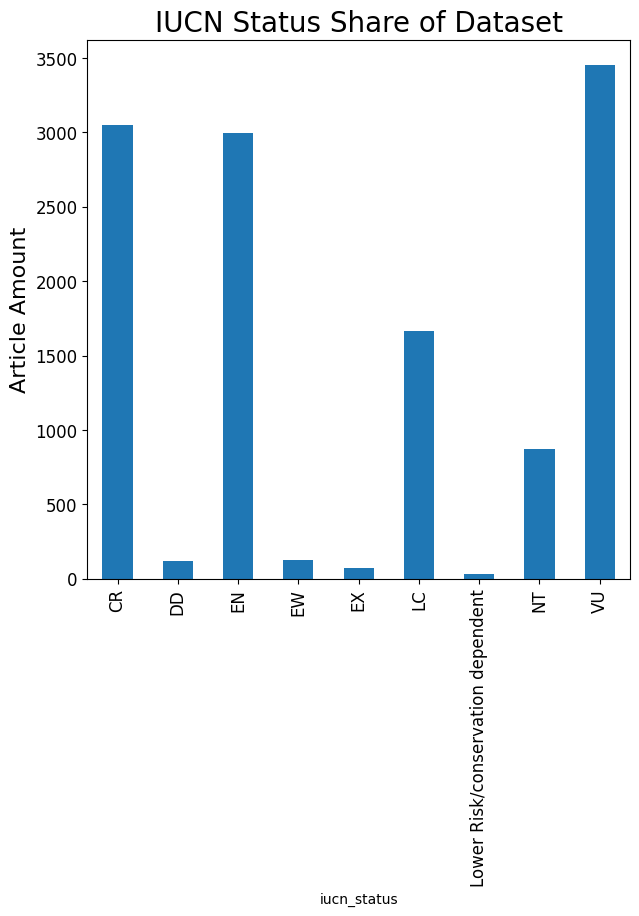

In [40]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_i = df_mod.groupby('iucn_status')

# Calculate the totals of the group species
article_totals_i = grouped_i.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_i.plot.bar(cmap, figsize = (7,7), 
                                                fontsize = 12)
ax.set_ylabel('Article Amount', fontsize=16)
ax.set_title('IUCN Status Share of Dataset', fontsize = 20)
#plt.savefig('IUCN-share.png', bbox_inches = 'tight')

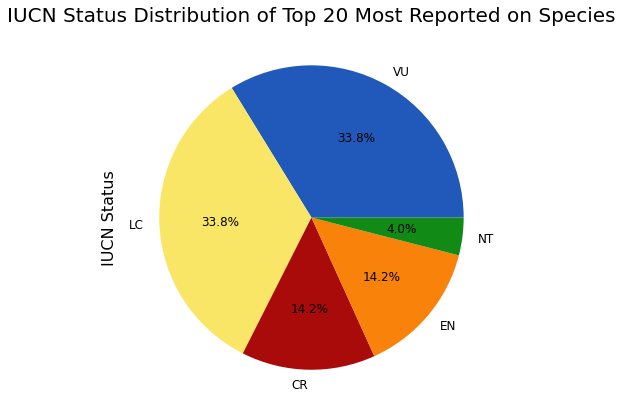

In [27]:
# Defining parameters for pie chart of IUCN Status
ax = top_twen['iucn_status'].value_counts().plot(kind = 'pie', autopct="%1.1f%%", figsize = (7,7), 
                                                fontsize = 12, colors = colors)

ax.set_ylabel('IUCN Status', fontsize=16)
ax.set_title('IUCN Status Distribution of Top 20 Most Reported on Species', fontsize = 20)
plt.savefig('IUCN-status.png', bbox_inches = 'tight')

In [32]:
# A quick look at the species' distribution
g = top_twen['article_amt'].groupby(top_twen['scientific_name'])



In [90]:
# Create a simplified version of the dataframe
smplfd = top_twen[['scientific_name', 'distribution', 'iucn_status']]
smplfd.drop_duplicates(inplace = True)
smplfd.reset_index(drop = True, inplace = True)
# Conduct merges of the dataframes
smplfd.merge(cites1, on = 'scientific_name', how = 'inner')
smplfd

In [35]:
# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')

In [42]:
# Group dataframe by the Kingdom that remains consistent for all rows 
grouped_k = df.groupby('Kingdom')

# Calculate the totals of the group Kingdom
article_totals_k = grouped_k.article_amt.sum().round()

In [43]:
article_totals_k

Kingdom
Animalia    13390.0
Plantae       175.0
Name: article_amt, dtype: float64

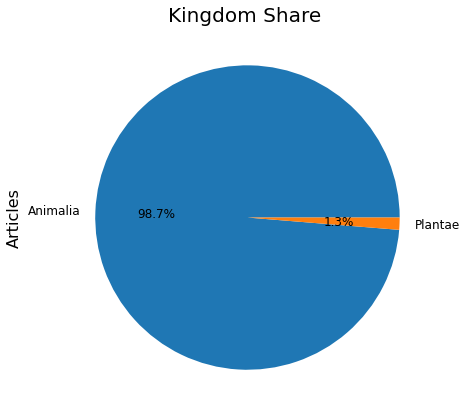

In [59]:
# What Kingdom is being reported on the most? 
# Create a simple pie chart displaying the amt of articles per Kingdom
ax = article_totals_k.plot.pie(y = 'Kingdom', autopct="%1.1f%%", figsize = (7,7), fontsize = 12)
ax.set_ylabel('Articles', labelpad = 35, fontsize=16)
ax.set_title('Kingdom Share ', fontsize = 20)
plt.savefig('Kingdom-Share.png', bbox_inches = 'tight')


In [73]:
df['Class'].value_counts()

Mammalia          1220
Aves               498
Reptilia           338
Actinopteri         46
Amphibia            30
Elasmobranchii      24
Bivalvia            24
Coelacanthi          9
Insecta              8
Name: Class, dtype: int64

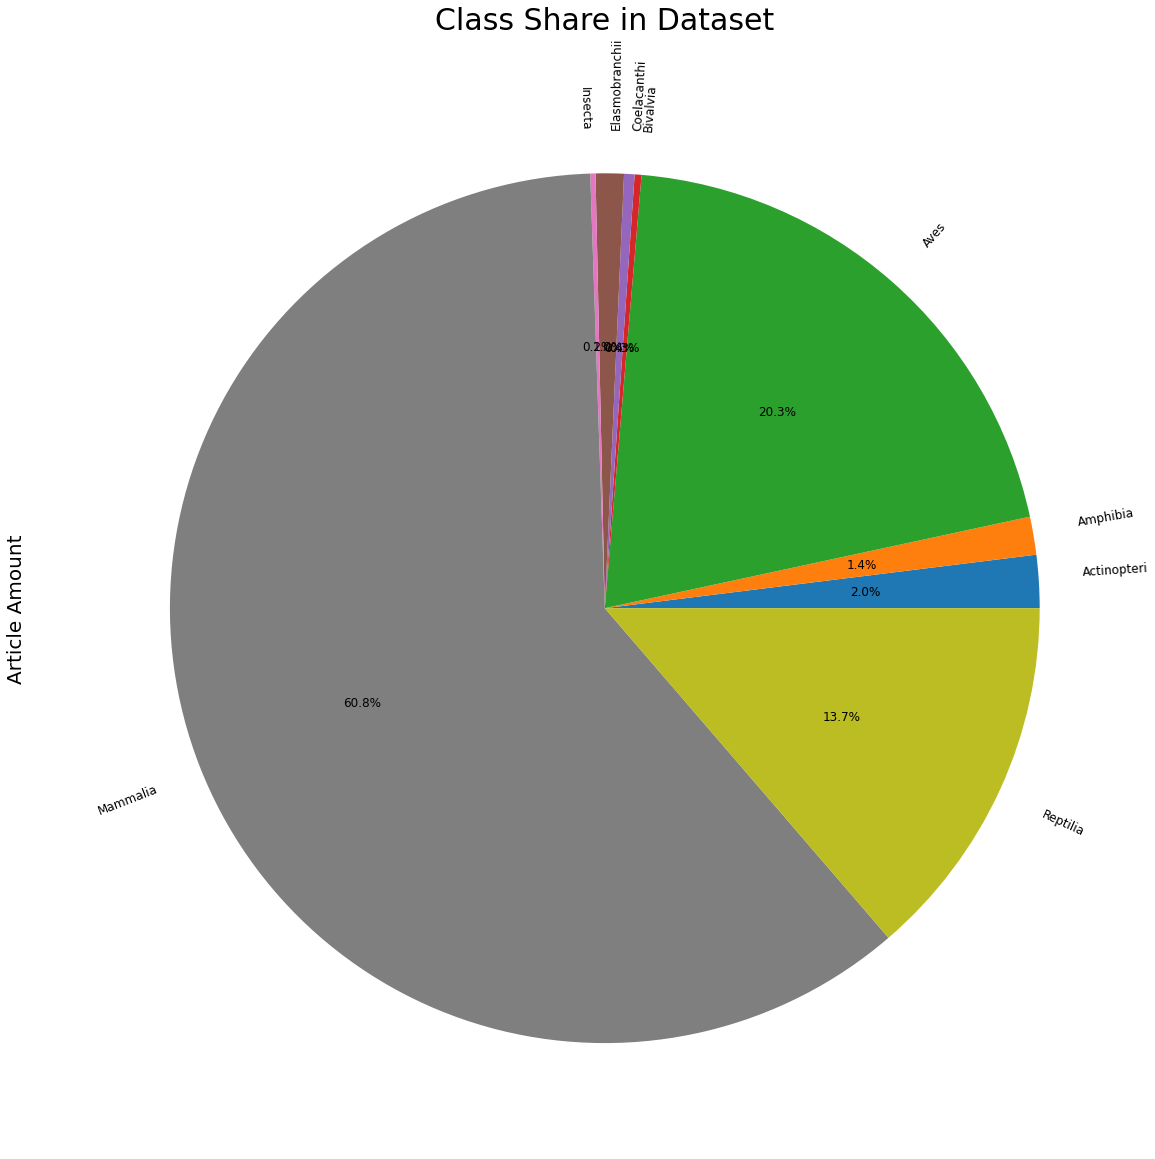

In [70]:
# Group dataframe by the Class that remains consistent for all rows 
grouped_c = df.groupby('Class')

# Calculate the totals of the Classes
article_totals_c = grouped_c.article_amt.sum().round()


# What Class is being reported on the most? 
# Create a simple pie graph displaying the amt of articles per species 
ax = article_totals_c.plot.bar(figsize = (20,20), autopct="%1.1f%%", fontsize = 12, rotatelabels=True)

ax.set_ylabel('Article Amount', labelpad = 35, fontsize=20)
ax.set_title('Class Share in Dataset', pad = 35, fontsize = 30)
plt.savefig('class-share.png', bbox_inches = 'tight')

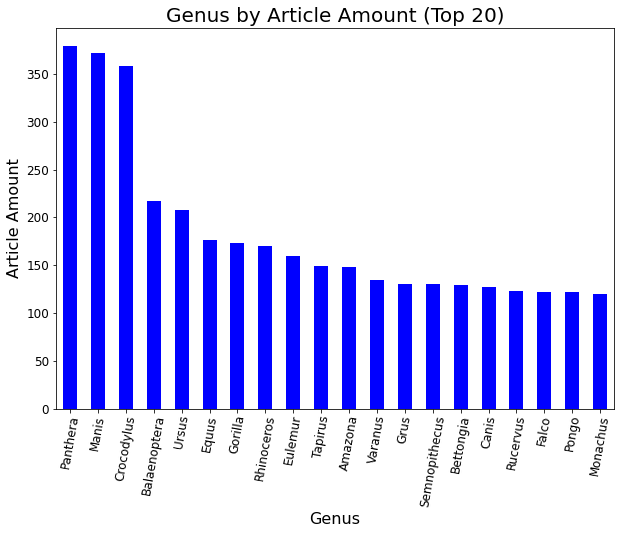

In [78]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_G = df.groupby('Genus')

# Calculate the totals of the group species
article_totals_G = grouped_G.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_G.nlargest(20).plot.bar(color = 'blue', figsize = (10,7), fontsize = 12)
ax.set_xlabel('Genus', fontsize=16)
ax.set_ylabel('Article Amount', fontsize = 16)
ax.set_title('Genus by Article Amount (Top 20)', fontsize = 20)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
plt.savefig('top_20_genus.png', bbox_inches = 'tight')

13/04/22

Next visualization step:
- Don't just visualize the dataset, look at the corresponding articles published for that class! for that genus! SO need to do groupby functions 